<a href="https://colab.research.google.com/github/Taran1504/python-programming/blob/main/Insurance_cost_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insurance cost dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [2]:
# Function to print cross validation scores, their mean and std dev
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [5]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Quick look at data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
# Inspecting categories in sex column
data["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [8]:
# Inspecting categories in smoker column
data["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [10]:
# Inspecting categories in region column
data["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [11]:
# Finding the summary of each numerical attribute
data.iloc[:, [0, 2, 3, 6]].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


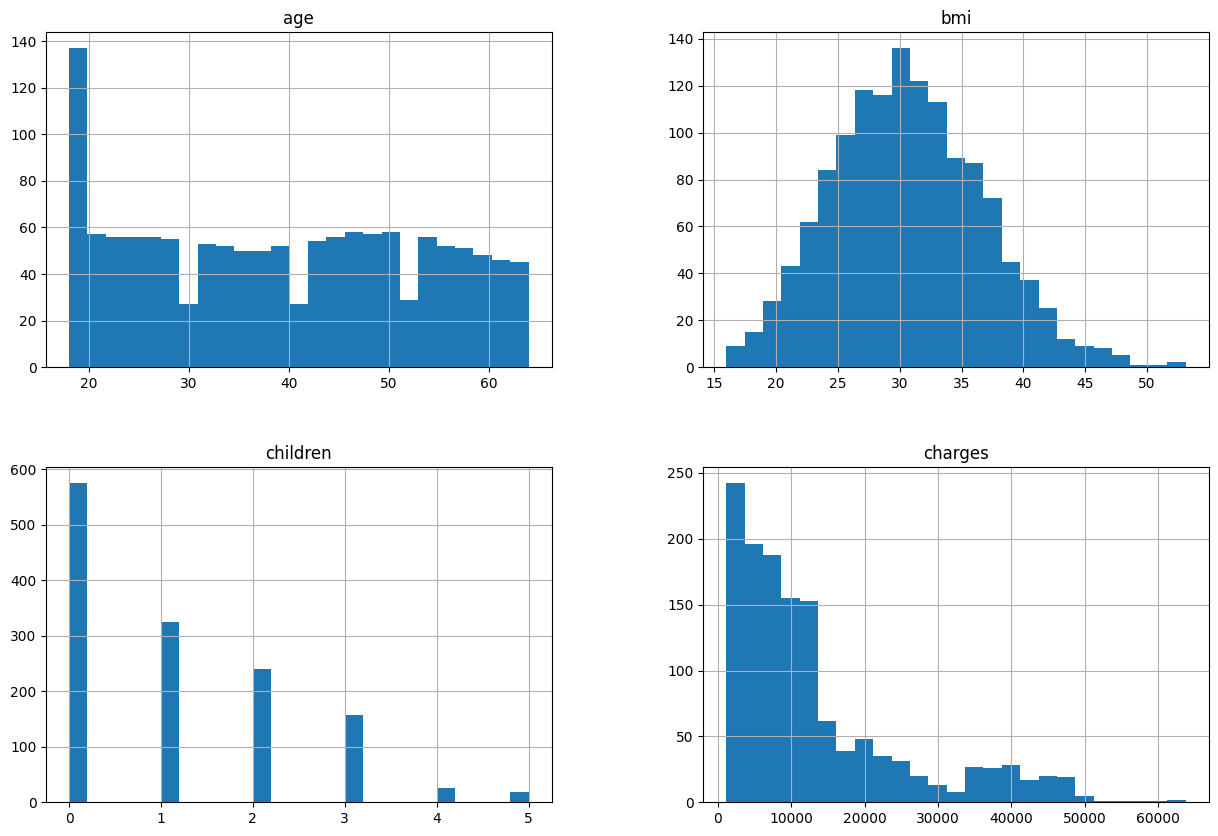

In [12]:
# Another way to have a feel of data is to prepare a histogram for each numerical attribute
data.hist(bins=25, figsize=(15, 10))
plt.show()

Above histograms shows that the attributes are of different ranges hence requires feature scaling.

Secondarily if the distribution of data is not bellshaped this becomes little difficult for a ML algorithm to work properly.

## Create a test set

In [13]:
train, test = train_test_split(data,
                               test_size=0.2,
                               random_state=42)

In [14]:
train.head()

,age,sex,bmi,children,smoker,region,charges
560,46,female,19.95,2,no,northwest,9193.83850
1285,47,female,24.32,0,no,northeast,8534.67180
1142,52,female,24.86,0,no,southeast,27117.99378
969,39,female,34.32,5,no,southeast,8596.82780
486,54,female,21.47,3,no,northwest,12475.35130


In [15]:
test.head()

,age,sex,bmi,children,smoker,region,charges
764,45,female,25.175,2,no,northeast,9095.06825
887,36,female,30.020,0,no,northwest,5272.17580
890,64,female,26.885,0,yes,northwest,29330.98315
1293,46,male,25.745,3,no,northwest,9301.89355
259,19,male,31.920,0,yes,northwest,33750.29180


## Visualize the data to gain insights

### looking for correlations

In [16]:
# Compute the standard correlation coefficient between every pair of attributes
train_data = train.copy() # make a copy of training set
train_data.corr(numeric_only=True)["charges"].sort_values(ascending=False)

charges     1.000000
age         0.281721
bmi         0.197316
children    0.071885
Name: charges, dtype: float64

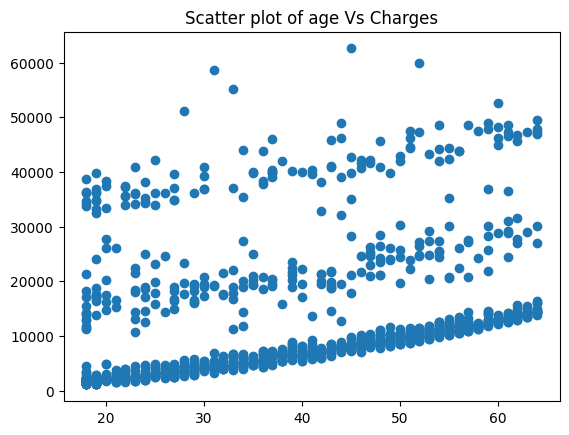

In [17]:
### Scatter plots of most promising attributes
plt.scatter(train_data["age"], train_data["charges"])
plt.title("Scatter plot of age Vs Charges")
plt.show()

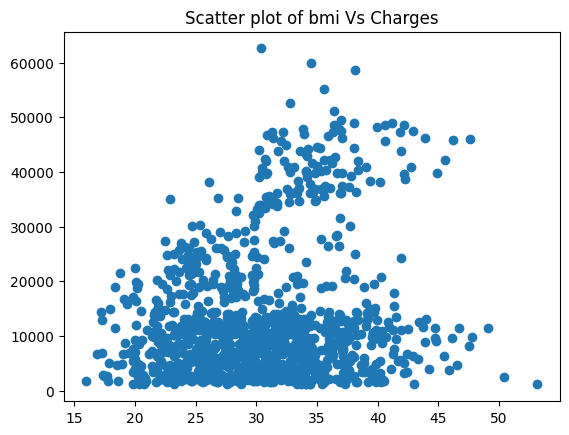

In [18]:
plt.scatter(train_data["bmi"], train_data["charges"])
plt.title("Scatter plot of bmi Vs Charges")
plt.show()

 no plot reveals good  and strong correlation

### Experimenting with attribute combination

In [19]:
train_data["bmi_vs_age"] = train_data["bmi"]/train_data["age"]
train_data.corr(numeric_only=True)["charges"].sort_values(ascending=False)

charges       1.000000
age           0.281721
bmi           0.197316
children      0.071885
bmi_vs_age   -0.141372
Name: charges, dtype: float64

A new attribute bmi_vs_age can be generated, we will further look if this attribute adds some benifit or not

## Prepare the data for machine learning algorithm

In [20]:
# Separate training features and labels from training data
trg_features = train.drop("charges", axis=1)
trg_labels = train["charges"].copy()

In [21]:
# Transformer to add a feature - bmi_vs_age
# A hyperparameter is provided so that it can return the same dataframe when that hyperparameter is False
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_feature=True): # no *args or **kargs
        self.add_feature = add_feature

    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X, y=None):
        X_C = X.copy()
        if self.add_feature:
            X_C["bmi_vs_age"] = X_C["bmi"]/X_C["age"]
        return X_C.to_numpy()

In [22]:
num_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [23]:
num_attribs = ["age", "bmi", "children"]
cat_attribs = ["sex", "smoker", "region"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [24]:
# Getting the training features ready prepared
trg_features_prepared = full_pipeline.fit_transform(trg_features)
trg_features_prepared

array([[ 0.47222651, -1.75652513,  0.73433626, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.54331294, -1.03308239, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8987451 , -0.94368672, -0.91119211, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16755139,  2.82086429,  0.73433626, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.1120044 , -0.10932713, -0.91119211, ...,  0.        ,
         0.        ,  1.        ]])

## Select and train a model

### Training and evaluation on training set

#### With Linear regression

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(trg_features_prepared, trg_labels)

LinearRegression()

In [26]:
some_features = trg_features_prepared[:10, :]
lin_reg.predict(some_features)

array([ 7325.38849001,  8260.19673902,  9308.98011015, 10952.6155617 ,
       10841.62234724, 17487.0402463 ,   915.28304409, 23639.66901194,
       11959.13096974, 32608.58932315])

In [27]:
# top 10 labels
trg_labels.iloc[:10]

560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
486     12475.35130
170     13405.39030
277      2150.46900
1033    13747.87235
209      6610.10970
947     39047.28500
Name: charges, dtype: float64

In [28]:
# It is clear that the predictions are not that accurate, let us measure the model rmse on whole training set.
lin_reg_predictions = lin_reg.predict(trg_features_prepared)
lin_mse = mean_squared_error(trg_labels, lin_reg_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6086.66057734032

Linear regression predictions indicate underfitting. Can we do better ?

Let us choose decision tree as the next algorithm to try

#### With decision tree

In [29]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(trg_features_prepared, trg_labels)

DecisionTreeRegressor()

In [30]:
# rmse on training set using decision tree regressor
tree_reg_predictions = tree_reg.predict(trg_features_prepared)
tree_mse = mean_squared_error(trg_labels, tree_reg_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

494.20598375812835

The rmse of decision tree is very low in comparison to linear regression, chances are that there may be overfitting, lets do cross validation to check it

In [31]:
scores = cross_val_score(tree_reg, trg_features_prepared, trg_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [6179.14418075 6211.64309235 7324.49752098 6421.53344182 7041.0267112
 5635.66211435 7137.3304593  6814.07541962 6844.33639706 5798.69998026]
Mean: 6540.794931768414
Standard deviation: 548.6730993583279


Above cross validation score clearly shows that decision tree is overfitting as the cross validation score is quiet high as compared to rmse on training set

In [32]:
# lets compute the same score for the linear regression model
lin_scores = cross_val_score(lin_reg, trg_features_prepared, trg_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6023.45264096 6600.07377791 5187.63536226 5952.54109371 5825.89223509
 6187.38054373 7236.35360673 6295.61429045 6293.48514086 5630.76758282]
Mean: 6123.3196274503325
Standard deviation: 526.7446297739888


This also shows that decision tree is overfitting and it performs worse than linear regression. Lets try one last model now random forest regressor

#### With random forest regressor

In [33]:
forest_reg = RandomForestRegressor()
forest_reg.fit(trg_features_prepared, trg_labels)

RandomForestRegressor()

In [34]:
# rmse on training set with random forest regressor
forest_reg_predictions = forest_reg.predict(trg_features_prepared)
forest_mse = mean_squared_error(trg_labels, forest_reg_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1860.647836024941

In [35]:
# Cross validation scores on random forest
forest_scores = cross_val_score(forest_reg, trg_features_prepared, trg_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [4922.43639327 5234.22169811 4010.69201856 4340.27463335 5325.71767507
 4849.37017887 5480.3339635  5364.80699943 5136.60663188 4747.58125931]
Mean: 4941.204145135123
Standard deviation: 448.9139155468413


Random forest looks very good as compared to linear regression and decision tree. How ever the model is still overfitting the training set

## Fine tune your model

In [36]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 20, 40], 'max_features': [2, 3, 4, 6, 8]}
]
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error")
grid_search.fit(trg_features_prepared, trg_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 50]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4, 6, 8],
                          'n_estimators': [3, 10, 20, 40]}],
             scoring='neg_mean_squared_error')

In [37]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 50}

In [38]:
best_model = grid_search.best_estimator_

## Evaluate system on test set

In [39]:
# Separate features & Labels from test set
test_features = test.drop("charges", axis=1)
test_labels = test["charges"].copy()

In [40]:
# Preprocessing on test features
test_features_prepared = full_pipeline.transform(test_features)
test_features_prepared

array([[ 0.40114007, -0.89153925,  0.73433626, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23863782, -0.08946143, -0.91119211, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.75178229, -0.60845296, -0.91119211, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.09646495, -0.41972876, -0.08842793, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.04091797,  2.78941026, -0.91119211, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.82765867,  0.60252728, -0.08842793, ...,  0.        ,
         0.        ,  1.        ]])

In [41]:
# Predictions on test set
test_pred = best_model.predict(test_features_prepared)

In [42]:
# RMSE on test set
test_mse = mean_squared_error(test_labels, test_pred)
test_rmse = np.sqrt(test_mse)
test_rmse

4454.125730635701

In [43]:
r2_score(test_labels, test_pred)

0.872209995961466